In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
SEED = 20240204
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [2]:
import kagglehub
import os
import shutil
import random

path = kagglehub.dataset_download("biaiscience/dogs-vs-cats")

original_train_dir = os.path.join(path, 'train/train')

SEED = 20240204
random.seed(SEED)

base_dir = 'exam_dataset'
for split in ['train', 'test']:
    for animal in ['cats', 'dogs']:
        os.makedirs(os.path.join(base_dir, split, animal), exist_ok=True)
os.makedirs('results', exist_ok=True)

def split_data(animal, prefix):
    all_imgs = [f for f in os.listdir(original_train_dir) if f.startswith(prefix)]
    selected = random.sample(all_imgs, 1000)

    for i, img in enumerate(selected):
        split = 'train' if i < 800 else 'test'
        dest = os.path.join(base_dir, split, animal + 's', img)
        shutil.copyfile(os.path.join(original_train_dir, img), dest)

split_data('cat', 'cat')
split_data('dog', 'dog')

print("Dataset hazırlandı: 1600 training, 400 test şəkli.")

Using Colab cache for faster access to the 'dogs-vs-cats' dataset.
Dataset hazırlandı: 1600 training, 400 test şəkli.


In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
import torch.nn as nn
class CatDogModel(nn.Module):
    def __init__(self):
        super(CatDogModel, self).__init__()


        self.features = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),


            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CatDogModel().to(device)

In [19]:
print(model)

CatDogModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [6]:
v1_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
v2_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
train_ds_v1 = datasets.ImageFolder(root='exam_dataset/train', transform=v1_transform)
test_ds = datasets.ImageFolder(root='exam_dataset/test', transform=test_transform)

train_loader_v1 = DataLoader(train_ds_v1, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

train_ds_v2 = datasets.ImageFolder(root='exam_dataset/train', transform=v2_transform)
train_loader_v2 = DataLoader(train_ds_v2, batch_size=32, shuffle=True)

In [21]:
def train_model(model, train_loader, lr, epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {'loss': [], 'acc': []}

    model.train()
    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            running_loss += loss.item()
            _,predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_acc = 100 * correct / total
        history['loss'].append(running_loss/len(train_loader))
        history['acc'].append(epoch_acc)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f} - Acc: {epoch_acc:.2f}%")
    return history
print("Versiya 1 is training(Normal Data)...")
model_v1 = CatDogModel().to(device)
history_v1 = train_model(model_v1, train_loader_v1, lr=0.001)

print("\nVersiya 2 is training (Augmented Data)...")
model_v2 = CatDogModel().to(device)
history_v2 = train_model(model_v2, train_loader_v2, lr=0.0001)

Versiya 1 is training(Normal Data)...
Epoch 1/20 - Loss: 0.7102 - Acc: 50.62%
Epoch 2/20 - Loss: 0.6865 - Acc: 56.19%
Epoch 3/20 - Loss: 0.6671 - Acc: 61.00%
Epoch 4/20 - Loss: 0.6305 - Acc: 63.19%
Epoch 5/20 - Loss: 0.5985 - Acc: 68.62%
Epoch 6/20 - Loss: 0.5436 - Acc: 72.56%
Epoch 7/20 - Loss: 0.4866 - Acc: 75.00%
Epoch 8/20 - Loss: 0.4044 - Acc: 81.38%
Epoch 9/20 - Loss: 0.3286 - Acc: 86.00%
Epoch 10/20 - Loss: 0.2263 - Acc: 90.50%
Epoch 11/20 - Loss: 0.1641 - Acc: 93.75%
Epoch 12/20 - Loss: 0.0917 - Acc: 96.81%
Epoch 13/20 - Loss: 0.0678 - Acc: 98.00%
Epoch 14/20 - Loss: 0.0570 - Acc: 98.25%
Epoch 15/20 - Loss: 0.0696 - Acc: 97.56%
Epoch 16/20 - Loss: 0.0485 - Acc: 98.50%
Epoch 17/20 - Loss: 0.0467 - Acc: 98.00%
Epoch 18/20 - Loss: 0.0268 - Acc: 99.19%
Epoch 19/20 - Loss: 0.0326 - Acc: 98.88%
Epoch 20/20 - Loss: 0.0277 - Acc: 99.19%

Versiya 2 is training (Augmented Data)...
Epoch 1/20 - Loss: 0.6948 - Acc: 52.19%
Epoch 2/20 - Loss: 0.6704 - Acc: 60.12%
Epoch 3/20 - Loss: 0.6573 - 

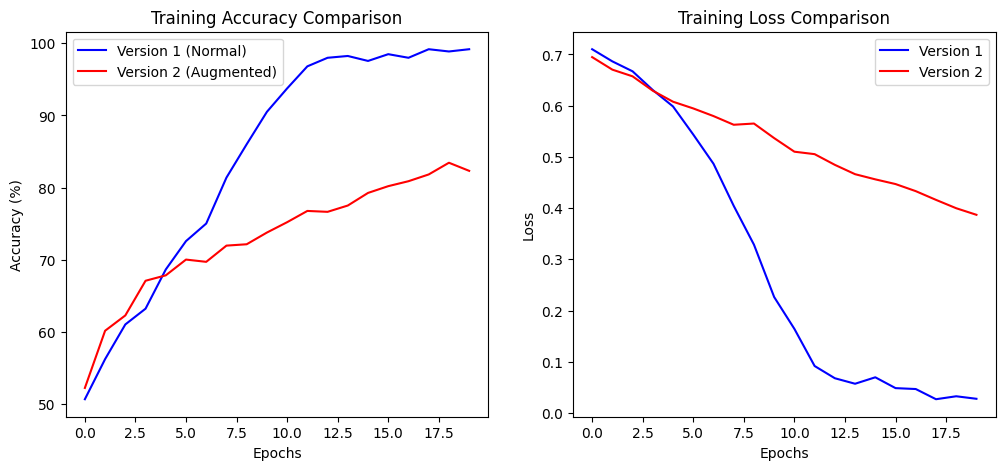

In [22]:
import matplotlib.pyplot as plt

def plot_results(h1, h2):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(h1['acc'], label='Version 1 (Normal)', color='blue')
    plt.plot(h2['acc'], label='Version 2 (Augmented)', color='red')
    plt.title('Training Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(h1['loss'], label='Version 1', color='blue')
    plt.plot(h2['loss'], label='Version 2', color='red')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig('results/training_comparison.png')
    plt.show()

plot_results(history_v1, history_v2)

Modelin çıxardığı ehtimallar: tensor([[ 1.5152, -1.9776],
        [-1.5776,  0.8499],
        [ 1.1069, -1.7468],
        [-0.4910,  0.1379],
        [ 0.7936, -0.9805],
        [-1.4610,  0.7664],
        [ 0.8544, -1.2863],
        [-0.3097, -0.1158],
        [-0.1607, -0.2908],
        [-2.7950,  2.2144]], device='cuda:0')


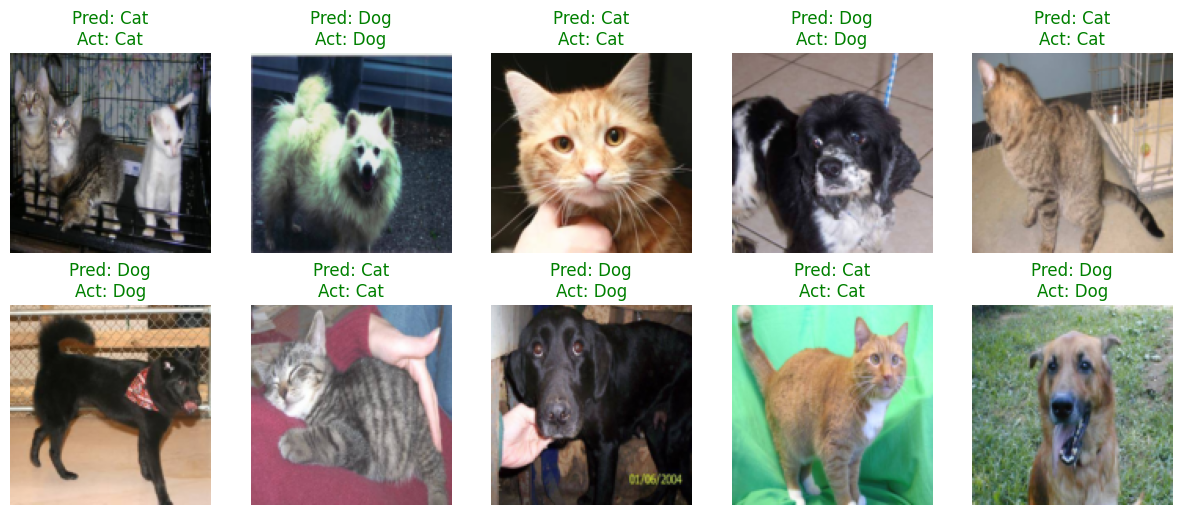

In [24]:
def show_10_samples(model, loader):
    model.eval()
    images, labels = next(iter(loader))

    indices = torch.randperm(len(images))[:10]
    images, labels = images[indices].to(device), labels[indices]

    with torch.no_grad():
        outputs = model(images)
        print("Modelin çıxardığı ehtimallar:", outputs)
        _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(15, 6))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)

        plt.imshow(img)

        plt.title(f"Pred: {'Dog' if preds[i].item()==1 else 'Cat'}\nAct: {'Dog' if labels[i].item()==1 else 'Cat'}",
                  color=("green" if preds[i] == labels[i] else "red"))
        plt.axis('off')

    plt.savefig('results/predictions.png')
    plt.show()
\
show_10_samples(model_v2, train_loader_v1)

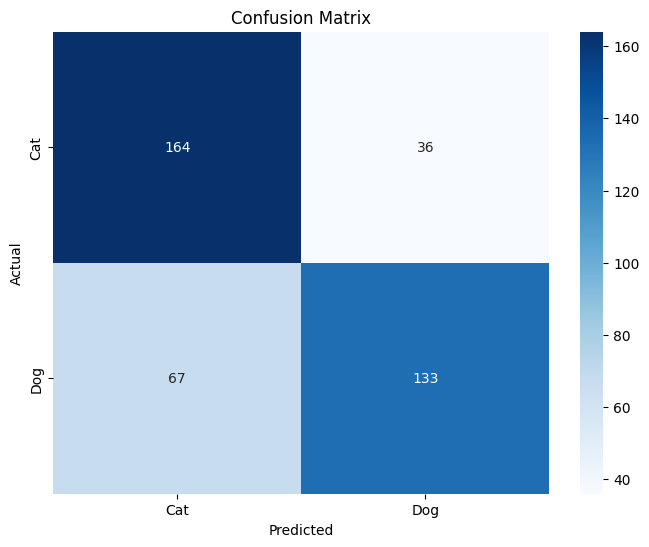

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('results/confusion_matrix.png')
    plt.show()

plot_confusion_matrix(model_v2, test_loader)

In [26]:
def check_final_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return 100 * correct / total

acc_v1 = check_final_accuracy(model_v1, test_loader)
acc_v2 = check_final_accuracy(model_v2, test_loader)

print("\n" + "="*30)
print(f"Versiya 1 Test Accuracy: {acc_v1:.2f}%")
print(f"Versiya 2 Test Accuracy: {acc_v2:.2f}%")
print("="*30)

torch.save(model_v2.state_dict(), 'results/cat_dog_model.pth')
print("\nFinal model 'results/cat_dog_model.pth' olaraq yadda saxlanıldı.")


Versiya 1 Test Accuracy: 69.75%
Versiya 2 Test Accuracy: 74.25%

Final model 'results/cat_dog_model.pth' olaraq yadda saxlanıldı.
